# Tutorial 1: Building ZenML Pipelines

This tutorial demonstrates how to build a complete ZenML pipeline.


In [1]:
import torch
import pytorch_lightning as pl

from torch_geometric.data import Data
from zenml import pipeline, step

from pioneerml.common.models import GroupClassifier
from pioneerml.common.pipeline.services.training.utils import GraphLightningModule
from pioneerml.pipelines.tutorial_examples.graph_datamodule import GraphDataModule
from pioneerml.common.zenml.materializers import (
    PyGDataListMaterializer,
)
from pioneerml.common.evaluation.plots import plot_loss_curves
from pioneerml.common.zenml import load_step_output
from pioneerml.common.zenml import utils as zenml_utils

# Initialize ZenML for notebook use
# setup_zenml_for_notebook automatically finds the project root by searching
# upward for .zen or .zenml directories, ensuring we use the root configuration.
# use_in_memory=True creates a temporary in-memory SQLite store, perfect for
# tutorials where we don't need persistent artifact storage.
zenml_client = zenml_utils.setup_zenml_for_notebook(use_in_memory=True)
print(f"ZenML initialized with stack: {zenml_client.active_stack_model.name}")


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).
ZenML initialized with stack: default


## Define the Training Pipeline

Here we build the pipeline steps directly in the notebook so you can see exactly how ZenML pipelines are composed. The cell below defines each step:

1. **`create_data`**: Generates synthetic graph data for a 3-class classification task
   - Uses `PyGDataListMaterializer` to serialize PyTorch Geometric data efficiently (avoids pickle warnings)
   
2. **`create_datamodule`**: Prepares the data for training
   - Splits data into train/validation sets (80/20 split)
   - Configures batch size and data loading workers
   
3. **`create_model`**: Instantiates the neural network architecture
   - Creates a `GroupClassifier` with appropriate hyperparameters
   
4. **`create_lightning_module`**: Wraps the model in PyTorch Lightning
   - Adds training logic, loss function, and optimizer configuration
   
5. **`train_model`**: Executes the training loop
   - Automatically detects available hardware (CPU/GPU)
   - Runs training for a specified number of epochs

**How ZenML wires steps together:** Steps communicate via return values. ZenML automatically matches step outputs to the next step's inputs based on function parameter names. Custom **materializers** control how artifacts are serialized to disk, keeping storage efficient and warnings quiet.



In [2]:

def create_simple_synthetic_data(num_samples: int = 200) -> list[Data]:
    """Generate clustered graphs so the model can learn a clear signal.
    
    Each class has distinct feature patterns:
    - pi cluster: boost feature 0
    - mu cluster: boost feature 1  
    - e+ cluster: negative drift across features
    """
    class_offsets = torch.tensor(
        [
            [2.0, 0.0, 0.5, 0.0, 0.0],   # pi cluster: boost feature 0
            [0.0, 2.0, 0.0, 0.5, 0.0],   # mu cluster: boost feature 1
            [-2.0, -2.0, -0.5, 0.0, 0.5],  # e+ cluster: negative drift
        ]
    )
    data: list[Data] = []
    for _ in range(num_samples):
        num_nodes = torch.randint(6, 10, (1,)).item()
        label = torch.randint(0, 3, (1,)).item()

        # Clustered node features with light noise make class boundaries learnable
        x = torch.randn(num_nodes, 5) * 0.4 + class_offsets[label]

        # Random edges with low-variance attributes keep the task simple
        edge_index = torch.randint(0, num_nodes, (2, num_nodes * 3))
        edge_attr = torch.randn(edge_index.shape[1], 4) * 0.3

        # One-hot encoded labels for multilabel classification
        y = torch.zeros(3)
        y[label] = 1.0
        data.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y))
    return data


@step(output_materializers=PyGDataListMaterializer, enable_cache=False)
def create_data() -> list[Data]:
    """Step 1: Generate synthetic graph data.
    
    The PyGDataListMaterializer ensures efficient serialization of PyTorch Geometric
    Data objects, avoiding pickle warnings.
    """
    return create_simple_synthetic_data()


@step(enable_cache=False)
def create_datamodule(data: list[Data]) -> GraphDataModule:
    """Step 2: Create data module with train/val split.
    
    - val_split=0.2: 80% train, 20% validation
    - batch_size=32: slightly larger for faster iteration
    - num_workers=0: keeps it portable for sandboxed runs
    """
    return GraphDataModule(dataset=data, val_split=0.2, batch_size=32, num_workers=0)


@step
def create_model(num_classes: int = 3) -> GroupClassifier:
    """Step 3: Instantiate the neural network architecture.
    
    Smaller hidden dim (64) and block count (1) to keep the tutorial quick on CPU.
    """
    return GroupClassifier(num_classes=num_classes, hidden=64, num_blocks=1)


@step
def create_lightning_module(model: GroupClassifier) -> GraphLightningModule:
    """Step 4: Wrap model in PyTorch Lightning module.
    
    Adds training logic, loss function (BCE for multilabel), and optimizer config.
    """
    return GraphLightningModule(model, task="classification", lr=1e-3)


@step
def train_model(lightning_module: GraphLightningModule, datamodule: GraphDataModule) -> GraphLightningModule:
    """Step 5: Execute training loop.
    
    Automatically detects available hardware (CPU/GPU) and runs for 3 epochs.
    Returns the trained module in eval mode.
    """
    import pytorch_lightning as pl
    from pioneerml.common.zenml.utils import detect_available_accelerator

    accelerator, devices = detect_available_accelerator()

    trainer = pl.Trainer(
        accelerator=accelerator,
        devices=devices,
        max_epochs=10,
        logger=False,
        enable_checkpointing=False,
        enable_progress_bar=False,
    )
    trainer.fit(lightning_module, datamodule=datamodule)
    return lightning_module.eval()


@pipeline
def basic_training_pipeline_demo():
    """Compose all steps into a complete training pipeline.
    
    ZenML automatically wires the outputs of one step to the inputs of the next
    based on parameter names. For example, `create_datamodule(data)` receives
    the output from `create_data()`.
    """
    data = create_data()
    datamodule = create_datamodule(data)
    model = create_model()
    lightning_module = create_lightning_module(model)
    trained_module = train_model(lightning_module, datamodule)
    return trained_module, datamodule



## Run the Pipeline

Execute the pipeline and load the artifacts. After the pipeline completes, we load the trained model and datamodule using `load_step_output`. These artifacts are stored by ZenML and can be reloaded anytime without re-running the pipeline.

**Why use `enable_cache=False`?** This ensures the pipeline runs fresh each time, which is useful for tutorials. In production, you'd typically enable caching to skip re-running unchanged steps.


Initiating a new run for the pipeline: basic_training_pipeline_demo.
Caching is disabled by default for basic_training_pipeline_demo.
Using user: default
Using stack: default
  deployer: default
  artifact_store: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step create_data has started.
Step create_data has finished in 0.198s.
Step create_model has started.
[create_model] No materializer is registered for type <class 'pioneerml.common.models.classifiers.group_classifier.GroupClassifierStereo'>, so the default Pickle materializer was used. Pickle is not production ready and should only be used for prototyping as the artifacts cannot be loaded when running with a different Python version. Please consider implementing a custom materializer for type <class 'pioneerml.common.models.classifiers.group_classifier.GroupClassifierStereo'> according to the instructions at https://docs.zenml

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
You are using a CUDA device ('NVIDIA GeForce RTX 5070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │ 65.6 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 65.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 65.6 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

[train_model] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[train_model] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.



`Trainer.fit` stopped: `max_epochs=10` reached.


[train_model] No materializer is registered for type <class 'pioneerml.common.pipeline.services.training.utils.graph_lightning_module.GraphLightningModule'>, so the default Pickle materializer was used. Pickle is not production ready and should only be used for prototyping as the artifacts cannot be loaded when running with a different Python version. Please consider implementing a custom materializer for type <class 'pioneerml.common.pipeline.services.training.utils.graph_lightning_module.GraphLightningModule'> according to the instructions at https://docs.zenml.io/concepts/artifacts/materializers
Step train_model has finished in 3.935s.
Pipeline run has finished in 6.557s.
Pipeline run status: completed
Loaded artifacts from run basic_training_pipeline_demo-2026_02_19-19_09_42_301408 (device=cuda)


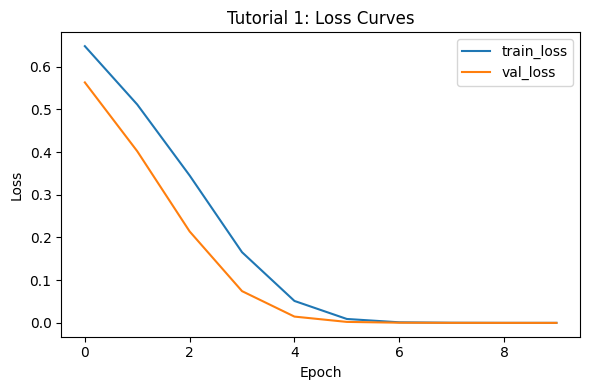

In [3]:
run = basic_training_pipeline_demo.with_options(enable_cache=False)()
print(f"Pipeline run status: {run.status}")

# Load artifacts from the run so we can inspect them locally
trained_module = load_step_output(run, "train_model")
datamodule = load_step_output(run, "create_datamodule")
model = getattr(trained_module, "model", None) if trained_module is not None else None

if trained_module is None or datamodule is None:
    raise RuntimeError("Could not load artifacts from the basic_training_pipeline run.")

# Move model to appropriate device and set up datamodule for evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_module = trained_module.to(device).eval()
datamodule.setup(stage="fit")

print(f"Loaded artifacts from run {run.name} (device={device})")
plot_loss_curves(trained_module, title="Tutorial 1: Loss Curves", show=True)



## Inspect the Outputs

Check the dataset size, batch shape, and key model parameters. This helps validate that the data/materializers round-tripped correctly and that the model configuration matches expectations.



In [4]:
device = next(trained_module.parameters()).device
train_loader = datamodule.train_dataloader()
first_batch = next(iter(train_loader))
train_size = len(datamodule.train_dataset) if datamodule.train_dataset is not None else 0
val_size = len(datamodule.val_dataset) if datamodule.val_dataset is not None else 0

print("Training summary:")
print(f"- Run: {run.name}")
print(f"- Device: {device}")
print(f"- Dataset size: {train_size + val_size} samples (train={train_size}, val={val_size})")
print(f"- Batch shape: x={tuple(first_batch.x.shape)}, edge_index={tuple(first_batch.edge_index.shape)}")

if model:
    print("\nModel configuration:")
    print(f"- Type: {type(model).__name__}")
    print(f"- Hidden dimension: {getattr(model, 'hidden', 'n/a')}")
    print(f"- Num classes: {getattr(model, 'num_classes', 'n/a')}")



Training summary:
- Run: basic_training_pipeline_demo-2026_02_19-19_09_42_301408
- Device: cuda:0
- Dataset size: 200 samples (train=160, val=40)
- Batch shape: x=(236, 5), edge_index=(2, 708)

Model configuration:
- Type: GroupClassifierStereo
- Hidden dimension: 64
- Num classes: n/a


## Evaluate on Validation Set

Compute a lightweight accuracy metric as a sanity check that training worked. Accuracy here is on a tiny synthetic validation set, so treat it as a smoke test rather than a real benchmark.

**How it's computed:**
- Apply `argmax` to model logits to get predicted class IDs
- Apply `argmax` to one-hot labels to get true class IDs  
- Compare predictions vs targets for exact match
- Average over the validation set

**Note on accuracy vs loss:** Accuracy measures whether the predicted class matches the true class (hard decision). Loss (BCE) measures how confident the model is - even with 100% accuracy, loss can be non-zero if logits aren't at the extremes. This is normal and expected.

**Interpretation:** >0.33 means the model is learning above random chance (3 classes).



In [5]:
val_loader = datamodule.val_dataloader()
# Verify we're using the validation set
val_size = len(datamodule.val_dataset) if datamodule.val_dataset is not None else 0
if val_size == 0:
    print("Warning: Validation dataset is empty, falling back to train loader")
    val_loader = datamodule.train_dataloader()
else:
    print(f"Evaluating on validation set ({val_size} samples)")

correct = 0
total = 0

for batch in val_loader:
    batch = batch.to(device)
    with torch.no_grad():
        logits = trained_module(batch)
    
    # Convert one-hot labels to class indices
    # batch.y should be [num_graphs_in_batch, num_classes] when batched
    labels = batch.y
    
    # Handle edge case: if labels are 1D, reshape them
    if labels.dim() == 1:
        # If labels are flattened, reshape based on logits shape
        if logits.shape[-1] > 0 and labels.numel() % logits.shape[-1] == 0:
            labels = labels.view(-1, logits.shape[-1])
        else:
            # If labels are already class indices (1D), keep them as is
            preds = torch.argmax(logits, dim=1)
            correct += int((preds == labels).sum().item())
            total += int(labels.numel())
            continue
    
    # Convert one-hot labels [num_graphs, num_classes] to class indices [num_graphs]
    if labels.dim() > 1:
        labels = torch.argmax(labels, dim=1)
    
    # Get predicted class indices from logits [num_graphs, num_classes] -> [num_graphs]
    preds = torch.argmax(logits, dim=1)
    
    # Count correct predictions
    correct += int((preds == labels).sum().item())
    total += int(labels.numel())

accuracy = correct / total if total else 0.0
print(f"Validation accuracy (quick check): {accuracy:.3f} ({correct}/{total} correct)")


Evaluating on validation set (40 samples)
Validation accuracy (quick check): 1.000 (40/40 correct)
